In [564]:
from models import BiLSTM, BiRNN
import modal
import torch 
import lab
import numpy as np
import matplotlib.pyplot as plt
import torch 
import scipy
import pydvma as dvma
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.patches as patches
import scienceplots
from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_fscore_support

In [2]:
plt.style.use('science')
plt.rcParams.update({"font.size":13})

In [1022]:
def generate_dat_extended(num_data, num_w_points, sigma_max = 0.15, max_modes = 7,
                multiclass = False, normalise = None, neg_an=False, logmag=False, scaled_logmag=False, a_max=2.0, method =1, norm_95=False):
    """Generate num_data training examples with num_w_points frequency points.
    Pass normalisation function as a parameter. Include phase and magnintude 
    information in the output.
    X: (num_data, num_w_points, 4)
    Y: (num_data, num_w_points)
    ws: (num_data, max_modes)
    zs: (num_data, max_modes)"""
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, max_modes + 1)
        w_n = np.random.uniform(0, 1, num_modes)
        if neg_an:
            if method == 1:
                a_n = np.random.uniform(-a_max, a_max, num_modes)
            elif method == 2:
                a_max=2.5
                mag = np.random.uniform(-a_max, a_max, num_modes)
                phase = np.random.normal(0, np.pi / 8, num_modes)
                a_n = mag * np.exp(1j * phase)  # combine mag and phase to make a complex num
        else:
            a_n = np.random.uniform(1, 2, num_modes)
        if method == 1:
            z_n = np.random.uniform(0.01, 0.20, num_modes)
        elif method == 2:
            z_n = 10 ** (np.random.uniform(-3, -0.7, num_modes)) # log-uniform sampling of z_n
            # z_n = np.random.uniform(0.001, 0.20, num_modes)
        # sigma = np.random.uniform(0.0001, sigma_max)

        # sigma = np.random.uniform(np.log(8*1e-2), sigma_max)
        sigma = np.random.uniform(np.log(1e-1), sigma_max)

        out, y = modal.modal_sum(w, a_n, z_n, w_n, sigma, multiclass)

        if normalise is not None:
            out = normalise(out)

        real_imag = modal.split_real_imag(out)
        phase = np.arctan(np.imag(out)/np.real(out))
        mag = np.abs(out)

        # phase = np.mod(phase, 2*np.pi)
        if norm_95 is True:
            max_mag = np.max(mag)
            mag = mag / (0.95 * max_mag)
            real_imag = real_imag / (0.95 * max_mag)

        if logmag is True:
            logmagnitude = np.log10(mag)
            if scaled_logmag is True:
                logmagnitude = (logmagnitude - np.mean(logmagnitude)) / np.std(logmagnitude)
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1), logmagnitude.reshape(-1,1)), axis=1)
        else:
            extended_op = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)
        ws.append(w_n)
        zs.append(z_n)
        X.append(extended_op)
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [374]:
def plot_tf(tf, y, todb=True, ws = None, figsize=(8,6)):
    """Plot transfer function and show training labels and mode frequencies."""
    fig, ax = plt.subplots(figsize=figsize)
    w = np.linspace(0, 1, len(y))

    mask = np.zeros_like(w)
    mask[y == 1] = 1
    if todb:
        # ax.scatter(w[y == 1], modal.to_db(tf)[y == 1], c='red', marker='o', label=r'Training Labels $(t_m = 1)$')
        ax.plot(w, modal.to_db(tf), label = 'Transfer Function', c='blue', alpha=0.7)

    ax.imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap='Greys', alpha=0.1)

    if ws is not None:
        for w_n in ws:
                ax.axvline(w_n, c='black', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Normalised Frequency')
    if todb:
        ax.set_ylabel('Magnitude (dB)')
    else:
        ax.set_ylabel('Magnitude')

    legend_elements = []
    # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Training Labels $(t_m = 1)$')]

    plt.show()
    return fig, ax

### Training Data (SHOULD FIX MAKE NEG_AN FALSE)

In [348]:
X, y, ws, __ = modal.generate_data(num_data=32*10, num_w_points=200, neg_an=True, max_modes=4, sigma_max=np.log(0.01))  # sigma_max = 0.15, max_modes = 7 (defaults)
valX, valy, _, __ = modal.generate_data(num_data=32*1, num_w_points=200, neg_an=True)

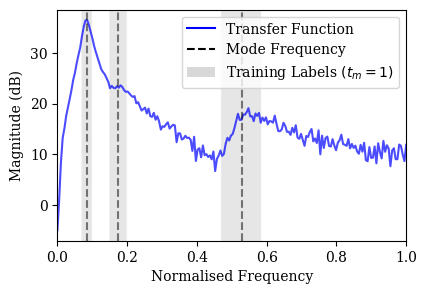

(<Figure size 450x300 with 1 Axes>,
 <Axes: xlabel='Normalised Frequency', ylabel='Magnitude (dB)'>)

In [177]:
idx = np.random.randint(0, X.shape[0])
plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

In [260]:
plt.style.use('science')
plt.rcParams.update({"font.size":13})

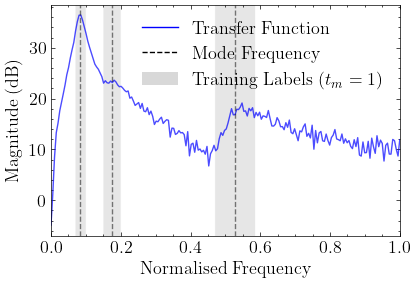

In [188]:
plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

In [189]:
X, y, ws, __ = modal.generate_data(num_data=32*10, num_w_points=200, neg_an=True, max_modes=4, sigma_max=np.log(0.01))  # sigma_max = 0.15, max_modes = 7 (defaults)

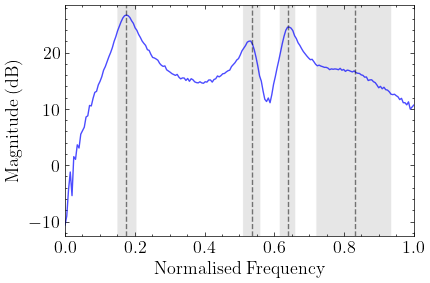

In [294]:
idx = np.random.randint(0, X.shape[0])
fig2, axs2 = plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

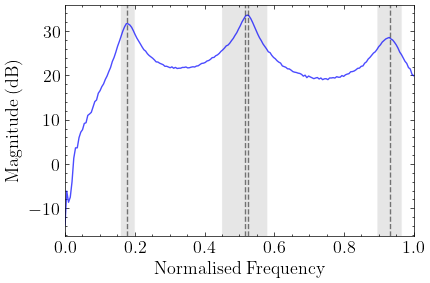

In [306]:
idx = np.random.randint(0, X.shape[0])
fig3, axs3 = plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

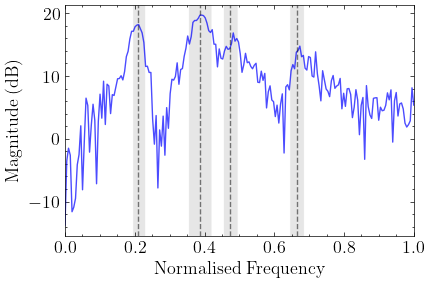

In [328]:
fig, ax = plot_tf(X[64], y[64], ws=ws[64], todb=True, figsize=(4.5, 3))
# fig.savefig('./Figs/training_noise.pdf')

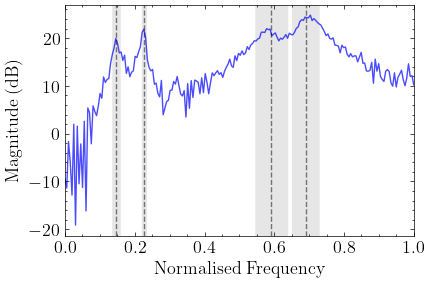

In [445]:
idx = np.random.randint(0, X.shape[0])
fig3, axs3 = plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

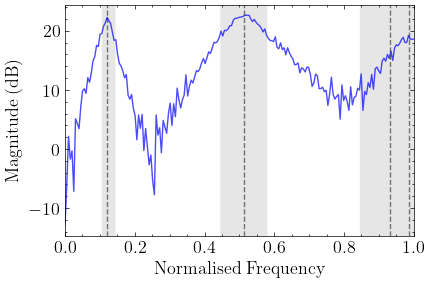

In [449]:
idx = np.random.randint(0, X.shape[0])
fig3, axs3 = plot_tf(X[idx], y[idx], ws=ws[idx], todb=True, figsize=(4.5, 3))

In [450]:
print(idx) #222, 161, 9

9


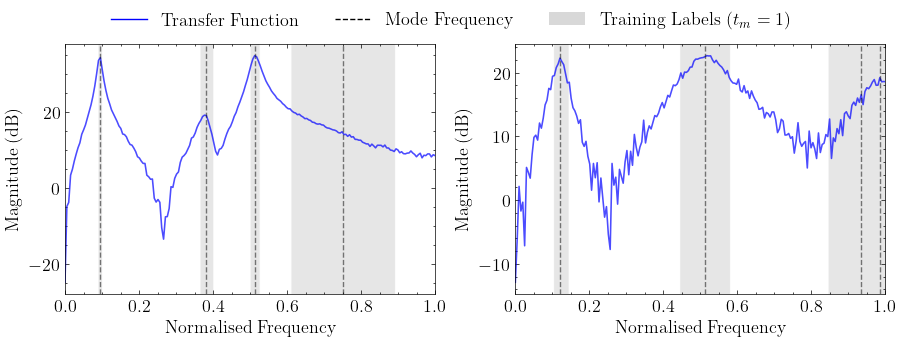

In [462]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (9,3), constrained_layout=True)

idx1 = 222
idx2 = 9

for i, idx in enumerate([idx1,idx2]):
    tf = X[idx]
    y2 = y[idx]
    w = np.linspace(0, 1, len(y2))
    mask = np.zeros_like(w)
    mask[y2 == 1] = 1
    ax[i].plot(w, modal.to_db(tf), label = 'Transfer Function', c='blue', alpha=0.7, linewidth=1.15)
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap='Greys', alpha=0.1)

    ws2 = ws[idx]
    if ws2 is not None:
        count = 0
        for w_n in ws2:
            count += 1
            if count == 1:
                ax[i].axvline(w_n, c='black', linestyle='--', label='Mode Frequency', alpha=0.5)
            else:
                ax[i].axvline(w_n, c='black', linestyle='--', alpha=0.5)

    ax[i].set_xlabel('Normalised Frequency')
    ax[i].set_ylabel('Magnitude (dB)')

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)

fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
           bbox_transform=fig.transFigure,
           ncol=3, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )
plt.savefig('./Figs/training.pdf')
plt.show()

### RNN vs LSTM

In [467]:
model1 = torch.load('./Models/rnn(17.01).pth')
model2 = torch.load('./Models/lstm_velocity_binary.pth')

In [160]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [985]:
def plot_predictions(
    val_inputs, val_outputs, val_targets, multiclass=False, nrows=4, ncols=4,ws=None, name=None,extended=False, figsize=(6, 5.5), show_legend=True,
):
    """Plot 4x4 grid of predictions on a validation set of data.
    val_inputs: (num_data, num_w_points, 2)
    val_outputs: (num_data, num_w_points)
    val_targets: (num_data, num_w_points)"""
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    w = np.linspace(0, 1, len(val_targets[0]))

    # Create a custom colormap with a single color
    single_color1 = mcolors.LinearSegmentedColormap.from_list("", ["white", "#fb9a99"]) # red
    single_color2 = mcolors.LinearSegmentedColormap.from_list("", ["white", "#a6cee3"]) # blue
    
    for index, ax in enumerate(axs.flat):

        targets = np.array(val_targets[index].numpy())
        test_op = np.array(val_outputs[index].numpy())

        if multiclass:
            tf_db = modal.to_db(val_inputs[index].numpy()[:, :2])

            predicted = np.argmax(test_op, axis=-1)
            ax.plot(w, tf_db, c="black", alpha=0.7, linewidth=1.15)

            segment_start = None
            segment_color = None
            
            for i in range(len(w)):
                if predicted[i] == 1 and (segment_start is None or segment_color != '#e31a1c'): #red
                    if segment_start is not None:
                        ax.plot(w[segment_start:i], tf_db[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = i
                    segment_color = '#e31a1c'
                elif predicted[i] == 2 and (segment_start is None or segment_color != 'royalblue'): #blue #1f78b4
                    if segment_start is not None:
                        ax.plot(w[segment_start:i], tf_db[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = i
                    segment_color = 'royalblue'
                elif predicted[i] != 1 and predicted[i] != 2 and segment_start is not None:
                    if i == segment_start + 1:
                        ax.scatter(w[segment_start], tf_db[segment_start], c=segment_color,alpha=0.7, s=50)
                    ax.plot(w[segment_start:i], tf_db[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = None
                    segment_color = None
            if segment_start is not None:
                ax.plot(w[segment_start:i], tf_db[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
            
            if ws is not None:
                for w_n in ws[index]:
                    ax.axvline(w_n, c='black', linestyle='--', alpha=0.4)

            mask = np.zeros_like(w)
            mask[targets == 1] = 1
            ax.imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap=single_color1, alpha=0.5) #

            mask2 = np.zeros_like(w)
            mask2[targets == 2] = 1
            ax.imshow(mask2.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap=single_color2, alpha=0.5)

            if show_legend:
                legend_elements = []
                legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
                legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
                rect = patches.Rectangle((0, 0), 1, 1, facecolor='#fb9a99', edgecolor='none', alpha=0.5, label='Training Labels (Class 1)')
                legend_elements.append(rect)
                rect = patches.Rectangle((0, 0), 1, 1, facecolor='#a6cee3', edgecolor='none', alpha=0.5, label='Training Labels (Class 2)')
                legend_elements.append(rect)
                legend_elements.append(plt.Line2D([0], [0], color='#e31a1c', alpha=0.7, linewidth=5, label='Model Predictions (Class 1)'))
                legend_elements.append(plt.Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=5, label='Model Predictions (Class 2)'))

                fig.legend(handles=legend_elements, loc='upper center', 
                        bbox_to_anchor=(0.5, 1.1),
                        # bbox_to_anchor=(0.5, -0),
                        bbox_transform=fig.transFigure,
                        ncol=3,
                        fancybox=True, 
                        #   shadow=True,
                            # frameon=True,
                            )


        else:
            predicted = (test_op > 0.0).astype(int)
            if extended is True:
                tf_db = modal.to_db(val_inputs[index].numpy()[:, :2])
            else:
                tf_db = modal.to_db(val_inputs[index].numpy())

            ax.plot(w, tf_db, c="blue", alpha=0.7, linewidth=1.15)

            mask = np.zeros_like(w)
            mask[predicted.reshape(-1) == 1] = 1
        
            segment_start = None
            for i in range(len(w)):
                if predicted[i] == 1:
                    if segment_start is None:
                        segment_start = i
                elif segment_start is not None:
                    ax.plot(w[segment_start:i], tf_db[segment_start:i], c="red", alpha=0.7, linewidth=5, label='Predicted=1')
                    segment_start = None
            
            if ws is not None:
                for w_n in ws[index]:
                    ax.axvline(w_n, c='black', linestyle='--', alpha=0.4)

            # ax.set_xlabel("Normalised Frequency")
            # ax.set_ylabel("Magnitude (dB)")

            mask = np.zeros_like(w)
            mask[targets == 1] = 1
            ax.imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax.get_ylim()[0], ax.get_ylim()[1]], cmap='Greys', alpha=0.1)

        # ax.set_ylim([-30, 60])
    # plt.legend()
    # plt.tight_layout()

    # fig.add_subplot(111, frameon=False)
    # # hide tick and tick label of the big axis
    # plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # plt.xlabel("Normalised Frequency")
    # plt.ylabel("Magnitude (dB)")
    fig.text(0.5, -0.01, 'Normalised Frequency', ha='center', va='center', fontsize=14)
    fig.text(-0.02, 0.5, 'Magnitude (dB)', ha='center', va='center', rotation='vertical', fontsize=14)


    if name is not None:
        plt.savefig(f'./Figs/{name}.pdf')

In [609]:
def compare_models(model1, model2, neg_an=False, extended=False, figsize=(6, 5.5), nrows=2,ncols=2):
    if extended:
        valX, valy, ws, __ = generate_dat_extended(32*1, 200, sigma_max=np.log(0.2), max_modes=7, neg_an=neg_an, logmag=False, scaled_logmag=False, method=1, norm_95=False)
    else:
        valX, valy, ws, __ = modal.generate_data(32*1, 200, neg_an=False, sigma_max=np.log(0.01), max_modes=5)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model1.eval()
    model2.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs1 = model1(val_inputs)
            val_outputs2 = model2(val_inputs)

    plot_predictions(val_inputs, val_outputs1, val_targets, ws=ws, nrows=nrows, ncols=ncols, extended=extended, figsize=figsize)
    plot_predictions(val_inputs, val_outputs2, val_targets, ws=ws, nrows=nrows, ncols=ncols, extended=extended, figsize=figsize, name='setA_good')

In [580]:
compare_models(model1, model2)

NameError: name 'compare_models' is not defined

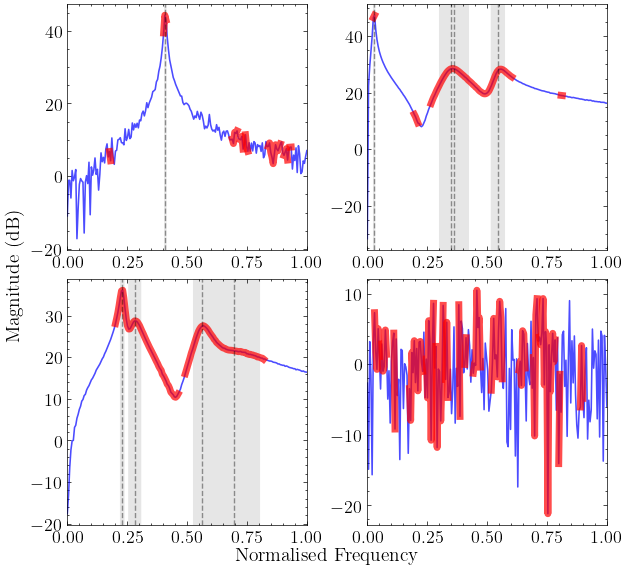

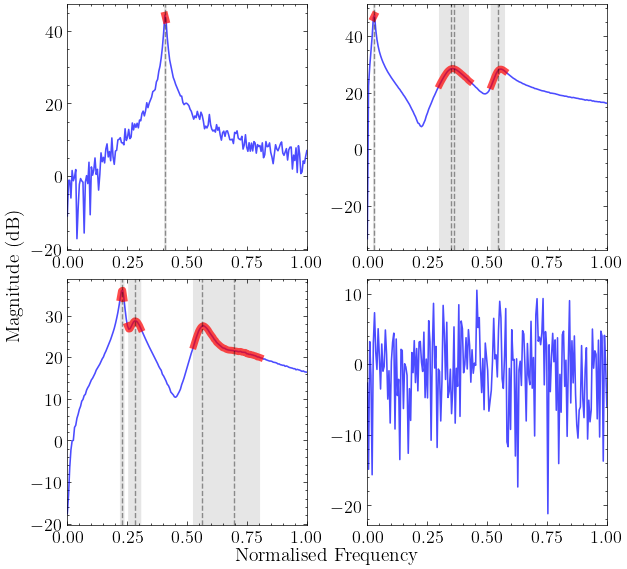

In [886]:
compare_models(model1, model2)

In [830]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))

legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=4, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

### RNN vs LSTM Table

In [833]:
def validate_model(
    model,
    num_w_points=200,
    sigma_max=0.15,
    neg_an=False,
    max_modes=5,
    extended=False,
    normalise=None,
    norm_95=True,
):
    if extended is True:
        valX, valy,_,__ = generate_dat_extended(
            32 * 250,
            num_w_points,
            sigma_max=sigma_max,
            # max_modes=max_modes,
            neg_an=True,
            max_modes=5,
            multiclass=False,
            normalise=normalise,
            norm_95=norm_95,

        )
    else:
        valX, valy, _, __ = modal.generate_data(
            32 * 150,
            num_w_points,
            sigma_max=sigma_max,
            max_modes=max_modes,
            neg_an=neg_an,
        )
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    total_val_loss = 0.0
    total_val_precision = 0.0
    total_val_recall = 0.0
    total_val_samples = 0

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([4.0])
    )  # Binary cross-entropy loss with logits

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            outputs = outputs.view(-1, 1)
            targets = targets.view(-1, 1)

            loss = criterion(outputs, targets.float())
            total_val_loss += loss.item() * len(inputs)
            batch_precision, batch_recall = modal.calculate_precision_and_recall_binary(
                outputs, targets
            )
            total_val_precision += batch_precision * len(inputs)
            total_val_recall += batch_recall * len(inputs)
            total_val_samples += len(inputs)

    average_val_loss = total_val_loss / total_val_samples
    average_val_precision = total_val_precision / total_val_samples
    average_val_recall = total_val_recall / total_val_samples

    print(f"Loss: {average_val_loss}")
    print(f"Precision: {average_val_precision}")
    print(f"Recall: {average_val_recall}")
    print(f"F_2: {5 * average_val_precision* average_val_recall / (average_val_recall + 4*average_val_precision)}")

In [844]:
validate_model(model1)

Loss: 0.6606395240624746
Precision: 0.5917395933843217
Recall: 0.9302263253748131
F_2: 0.8347299253728555


In [845]:
validate_model(model2)

Loss: 0.12170396854480107
Precision: 0.919905655717162
Recall: 0.9720918282414113
F_2: 0.9611862250726884


### Training Data Development

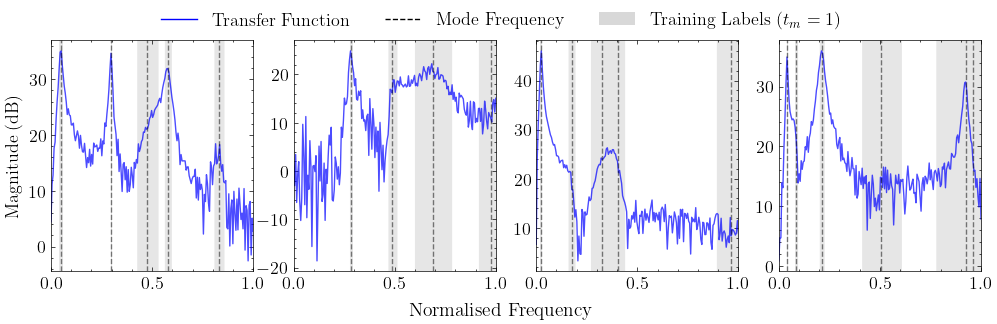

In [249]:
fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=4)
X1, y1, ws1, __ = generate_dat_extended(32*10, 200, method=1, neg_an=True, max_modes=6)
w = np.linspace(0, 1, X1.shape[1])
indices = np.random.randint(0, X1.shape[0], 4)

for i in range(4):
    tf = X1[indices[i],:,:2]
    mask = np.zeros_like(w)
    mask[y1[indices[i]] == 1] = 1
    ax[i].plot(w, modal.to_db(tf), label = 'Transfer Function', c='blue', alpha=0.7)
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap='Greys', alpha=0.1)

    if ws1[indices[i]] is not None:
        for w_n in ws1[indices[i]]:
                ax[i].axvline(w_n, c='black', linestyle='--', label='Mode Frequency', alpha=0.5)

ax[0].set_ylabel('Magnitude (dB)')
fig.text(0.5, -0.02, 'Normalised Frequency', ha='center', va='center', fontsize=14)

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)

fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.03),
        # bbox_to_anchor=(0.5, -0),
           bbox_transform=fig.transFigure,
           ncol=3, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )
plt.savefig('./Figs/training_setA.pdf')
plt.show()

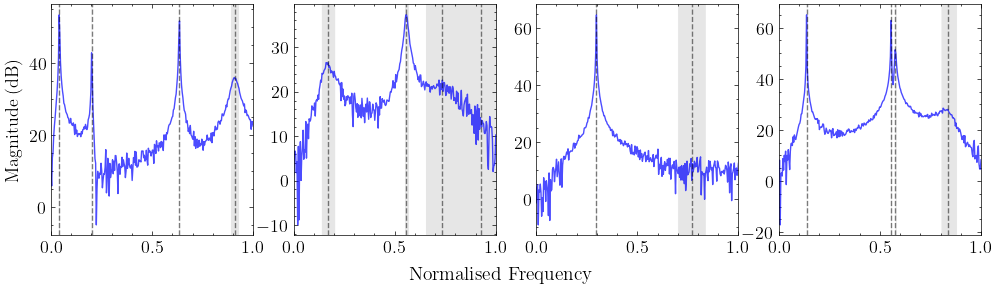

In [253]:
fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=4)
X1, y1, ws1, __ = generate_dat_extended(32*10, 300, method=2, neg_an=True, max_modes=6)
w = np.linspace(0, 1, X1.shape[1])
indices = np.random.randint(0, X1.shape[0], 4)

for i in range(4):
    tf = X1[indices[i],:,:2]
    mask = np.zeros_like(w)
    mask[y1[indices[i]] == 1] = 1
    ax[i].plot(w, modal.to_db(tf), label = 'Transfer Function', c='blue', alpha=0.7)
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap='Greys', alpha=0.1)

    if ws1[indices[i]] is not None:
        for w_n in ws1[indices[i]]:
                ax[i].axvline(w_n, c='black', linestyle='--', label='Mode Frequency', alpha=0.5)

ax[0].set_ylabel('Magnitude (dB)')
fig.text(0.5, -0.02, 'Normalised Frequency', ha='center', va='center', fontsize=14)

legend_elements = []

plt.savefig('./Figs/training_setB.pdf')
plt.show()

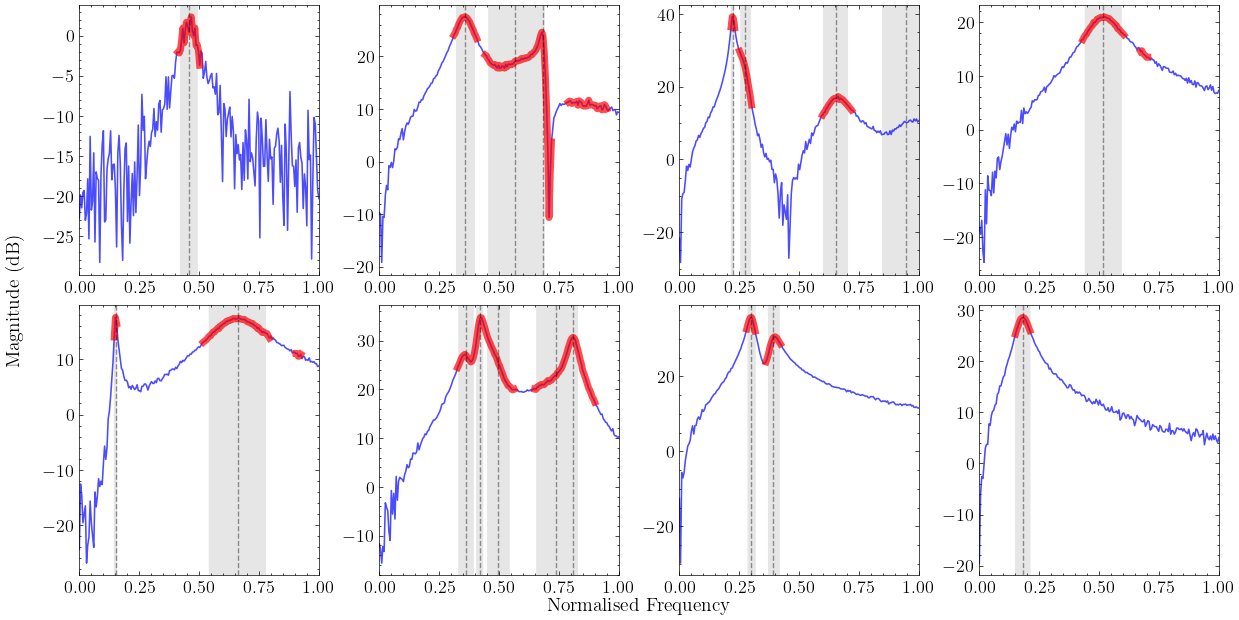

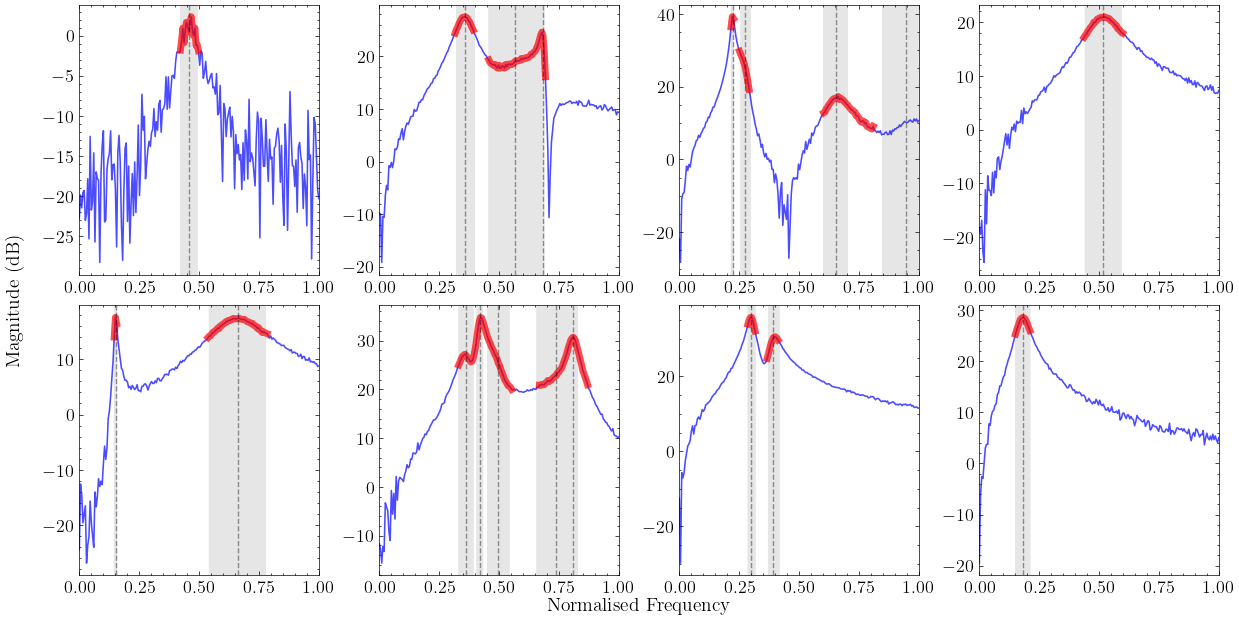

In [628]:
compare_models(jan1, jan2, neg_an=True, extended=True, figsize=(12,6), ncols=4)

### phase/mag features

In [269]:
X, y, ws, __ = generate_dat_extended(32*10, 200, sigma_max=0.001, neg_an=True, max_modes=4, multiclass=False, normalise=None, norm_95=False)

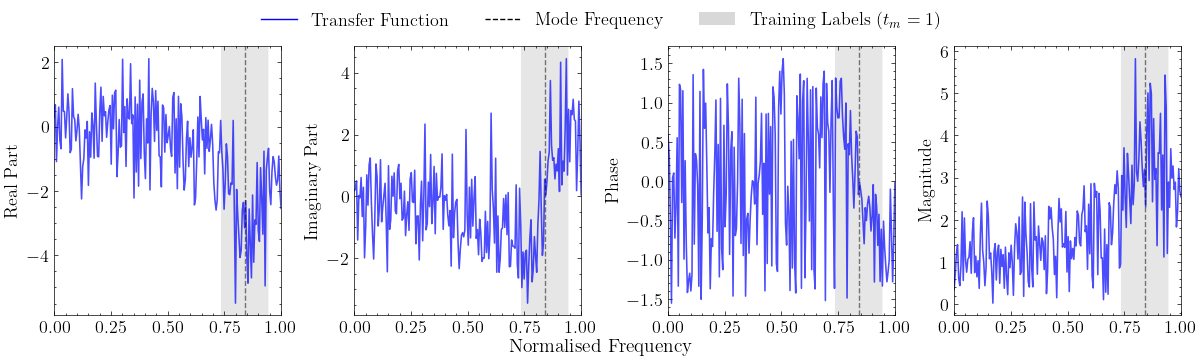

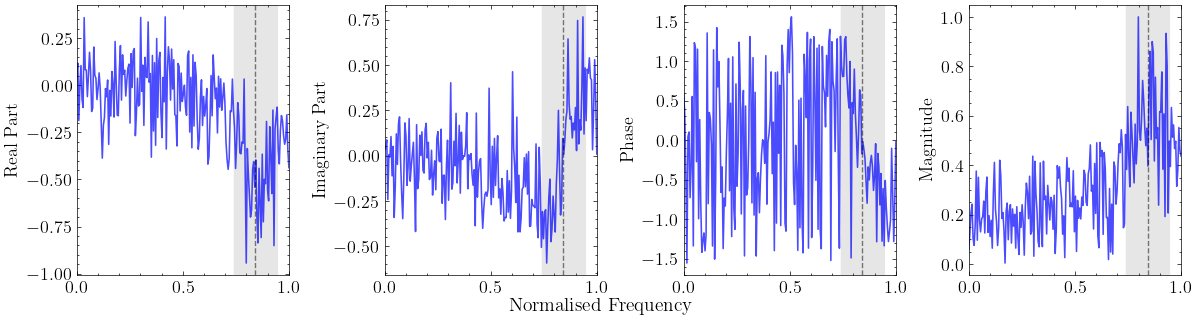

In [279]:
idx = np.random.randint(0, X.shape[0])
w = np.linspace(0, 1, X.shape[1])
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), constrained_layout=True)
for i in range(4):
    ax[i].plot(w, X[idx, :, i], c='blue', alpha=0.7, linewidth=1.15)
    mask = np.zeros_like(w)
    mask[y[idx] == 1] = 1
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap='Greys', alpha=0.1)
    if ws is not None:
        for w_n in ws[idx]:
            ax[i].axvline(w_n, c='black', linestyle='--', alpha=0.5)
    # ax[i].set_xlabel('Normalised Frequency')
fig.text(0.5, -0.02, 'Normalised Frequency', ha='center', va='center', fontsize=14)
ax[0].set_ylabel('Real Part')
ax[1].set_ylabel('Imaginary Part')
ax[2].set_ylabel('Phase')
ax[3].set_ylabel('Magnitude')
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)

fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
           bbox_transform=fig.transFigure,
           ncol=3, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )

# plt.savefig('./Figs/phase_mag_training.pdf')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), constrained_layout=True)
max_mag = np.max(X[idx,:,-1])
X[idx,:,-1] = X[idx,:,-1] / max_mag
X[idx,:,:2] = X[idx,:,:2] / max_mag
for i in range(4):
    ax[i].plot(w, X[idx, :, i], c='blue', alpha=0.7, linewidth=1.15)
    mask = np.zeros_like(w)
    mask[y[idx] == 1] = 1
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap='Greys', alpha=0.1)
    if ws is not None:
        for w_n in ws[idx]:
            ax[i].axvline(w_n, c='black', linestyle='--', alpha=0.5)
    # ax[i].set_xlabel('Normalised Frequency')
ax[0].set_ylabel('Real Part')
ax[1].set_ylabel('Imaginary Part')
ax[2].set_ylabel('Phase')
ax[3].set_ylabel('Magnitude')
fig.text(0.5, -0.02, 'Normalised Frequency', ha='center', va='center', fontsize=14)
# plt.savefig('./Figs/phase_mag_training_norm.pdf')
plt.show()


In [150]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='blue', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='grey', edgecolor='none', alpha=0.3, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)
# legend_elements.append(plt.Line2D([0], [0], color='red', alpha=0.7, linewidth=5, label='Model Predictions'))

legend = fig.legend(handles=legend_elements,
            # loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=3, 
        #   fancybox=True, 
        #   shadow=True,
            # frameon=True,
)
def export_legend(legend, filename="./Figs/legend_phasemag.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

### Feature Selection

In [817]:
def calculate_precision_and_recall_multiclass(outputs, targets):
    predicted = np.argmax(outputs, axis=-1)
    predicted = predicted.cpu().numpy()
    targets = targets.cpu().numpy()

    precision = precision_score(targets, predicted.reshape(-1), average='macro', zero_division=0)
    recall = recall_score(targets, predicted.reshape(-1), average='macro', zero_division=0)
    f2 = fbeta_score(targets, predicted.reshape(-1), average='macro', zero_division=0, beta=2)

    return precision, recall, f2

In [818]:
def calc(output, targets):
    predicted = np.argmax(output, axis=-1)
    predicted = predicted.cpu().numpy()
    targets = targets.cpu().numpy()
    return precision_recall_fscore_support(targets, predicted.reshape(-1), average=None, zero_division=0, beta=2)

In [819]:
def validate_model_multiclass(
    model,
    num_w_points=200,
    sigma_max=0.15,
    logmag=False,
    scaled_logmag=False,
    method=1,
):
    valX, valy, _, __ = generate_dat_extended(
        32 * 150,
        num_w_points,
        sigma_max=sigma_max,
        max_modes=6,
        neg_an=True,
        multiclass=True,
        logmag=logmag,
        scaled_logmag=scaled_logmag,
        method=method,
    )
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    total_val_precision = 0.0
    total_val_recall = 0.0
    total_val_f2 = 0.0
    total_val_samples = 0
    tot_p = np.zeros(3)
    tot_r = np.zeros(3)
    tot_f = np.zeros(3)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()  # !!!
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            targets = targets.view(-1)
            # predicted = np.argmax(outputs, axis=-1)

            batch_precision, batch_recall, batch_f2 = calculate_precision_and_recall_multiclass(
                outputs, targets
            )
            total_val_precision += batch_precision * len(inputs)
            total_val_recall += batch_recall * len(inputs)
            total_val_f2 += batch_f2 * len(inputs)
            total_val_samples += len(inputs)

            p, r, f, _ = calc(outputs, targets)
            tot_p += p * len(inputs)
            tot_r += r * len(inputs)
            tot_f += f * len(inputs)


    average_val_precision = total_val_precision / total_val_samples
    average_val_recall = total_val_recall / total_val_samples
    average_val_f2 = total_val_f2 / total_val_samples

    print(f"Precision: {average_val_precision}")
    print(f"Recall: {average_val_recall}")
    # print(f"F_2: {5 * average_val_precision* average_val_recall / (average_val_recall + 4*average_val_precision)}")
    print(f"F_2: {average_val_f2}")
    avg_p = tot_p / total_val_samples
    avg_r = tot_r / total_val_samples
    avg_f = tot_f / total_val_samples

    print(f"Class 0: p: {avg_p[0]:.3f}, r: {avg_r[0]:.3f}, F2: {avg_f[0]:.3f}")
    print(f"Class 1: p: {avg_p[1]:.3f}, r: {avg_r[1]:.3f}, F2: {avg_f[1]:.3f}")
    print(f"Class 2: p: {avg_p[2]:.3f}, r: {avg_r[2]:.3f}, F2: {avg_f[2]:.3f}")

In [633]:
class BiLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.0)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.droput = nn.Dropout(0.3)
        # self.bn = nn.BatchNorm1d(hidden_size*2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # out = out.permute(0, 2, 1)
        # out = self.bn(out)
        # sequence-to-sequence classification problem where you want to classify each time step in the sequence independently.
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.droput(out)
        return out

#### Extended models

In [830]:
jan1 = torch.load('./Models/Extended Models (Jan)/extended_model(15.01).pth')
jan2 = torch.load('./Models/Extended Models (Jan)/extended_model(15.01)_20epochs.pth')
jan3 = torch.load('./Models/Extended Models (Jan)/extended_model(15.01)_50epochs.pth')
jan1_norm = torch.load('./Models/Extended Models (Jan)/extended_model_norm(15.01).pth')
jan2_norm = torch.load('./Models/Extended Models (Jan)/extended_model_norm(15.01)_30epochs.pth')
jan3_norm = torch.load('./Models/Extended Models (Jan)/extended_model_norm(15.01)_50epochs.pth')
jan1_multi = torch.load('./Models/Extended Models (Jan)/extended_model_multiclass(15.01).pth')
jan2_multi = torch.load('./Models/Extended Models (Jan)/extended_model_multiclass(17.01)_150epochs.pth')
jan3_multi = torch.load('./Models/Extended Models (Jan)/extended_model_multiclass(18.01)_200epochs.pth')

In [834]:
print('jan1')
validate_model(jan1, extended=True, norm_95=False, sigma_max=np.log(0.2))
print('\njan2')
validate_model(jan2, extended=True, norm_95=False, sigma_max=np.log(0.2))
print('\njan3')
validate_model(jan3, extended=True, norm_95=False, sigma_max=np.log(0.2))

jan1
Loss: 0.23732518726587296
Precision: 0.8813695463564449
Recall: 0.9401223969182116
F_2: 0.9277534289199783

jan2
Loss: 0.1925208350121975
Precision: 0.9215738677853579
Recall: 0.9390535501401358
F_2: 0.935504767616903

jan3
Loss: 0.16354135060310362
Precision: 0.917077842031116
Recall: 0.9535441196630428
F_2: 0.9460206900158364


In [57]:
print("extended1")
validate_model(jan1, extended=True, norm_95=False)
print("\nextended2")
validate_model(jan2, extended=True, norm_95=False)
print("\nextended3")
validate_model(jan3, extended=True, norm_95=False)
print("\nextended1_norm")
validate_model(jan1_norm, extended=True, normalise=modal.normalise_rms, norm_95=False)
print("\nextended2_norm")
validate_model(jan2_norm, extended=True, normalise=modal.normalise_rms, norm_95=False)
print("\nextended3_norm")
validate_model(jan3_norm, extended=True, normalise=modal.normalise_rms, norm_95=False)
print("\nextended1_multi")
validate_model_multiclass(jan1_multi, norm_95=False)
print("\nextended2_multi")
validate_model_multiclass(jan2_multi, norm_95=False)
print("\nextended3_multi")
validate_model_multiclass(jan3_multi, norm_95=False)

extended1
Loss: 1.254037709236145
Precision: 0.33952343928591056
Recall: 0.957118492922499
F_2: 0.7018020972200512

extended2
Loss: 1.1419559041659038
Precision: 0.35140042346531897
Recall: 0.9432787824156428
F_2: 0.7055884003772298

extended3
Loss: 1.3481333525975545
Precision: 0.35093471015285116
Recall: 0.9309462612010092
F_2: 0.6996689962360206

extended1_norm
Loss: 0.5899016191562017
Precision: 0.8680216885036928
Recall: 0.7404415470309657
F_2: 0.7628664734816781

extended2_norm
Loss: 0.6898024618625641
Precision: 0.9162955296887776
Recall: 0.7368027826975442
F_2: 0.7668462195602024

extended3_norm
Loss: 0.9675264781713486
Precision: 0.8939669480520257
Recall: 0.7212399674516016
F_2: 0.7502310025463623

extended1_multi


TypeError: validate_model_multiclass() got an unexpected keyword argument 'norm_95'

#### Phase + Mag (norm95)

In [4]:
extended1 = torch.load('norm_95_max(07.02).pth')
extended2 = torch.load('norm_95_max(08.02).pth')
extended3 = torch.load('norm_95_max(09.02).pth')
extended4 = torch.load('norm_95_max(22.02).pth')
extended5 = torch.load('norm_95_max(22.02)_50epochs.pth')
extended6 = torch.load('norm_95_max(27.02).pth')
extended7 = torch.load('norm_95_max(28.02).pth')
extended8 = torch.load('norm_95_max(07.03).pth')

In [44]:
print('07.02 \n')
validate_model_multiclass(extended1, method=1)
print('08.02 \n')
validate_model_multiclass(extended2, method=1)
print('09.02 \n')
validate_model_multiclass(extended3, method=1)
print('22.02 \n')
validate_model_multiclass(extended4, method=1)
print('22.02_50epochs \n')
validate_model_multiclass(extended5, method=1)
print('27.02 \n')
validate_model_multiclass(extended6, method=2)
print('28.02 \n')
validate_model_multiclass(extended7, method=2)
print('07.03 \n')
validate_model_multiclass(extended8, method=2)

07.02 

Precision: 0.4089619736283228
Recall: 0.4529174517948401
F_2: 0.4433863653093283
F_2 (method 2) : 0.35508109896153245
08.02 

Precision: 0.6848864381901352
Recall: 0.6362823416169645
F_2: 0.6454433319029514
F_2 (method 2) : 0.640249979496105
09.02 

Precision: 0.6906866968189794
Recall: 0.6351529958631674
F_2: 0.6455336423756045
F_2 (method 2) : 0.6409347549678306
22.02 

Precision: 0.6117193249904772
Recall: 0.6089217245541608
F_2: 0.6094791956668316
F_2 (method 2) : 0.59415369505502
22.02_50epochs 

Precision: 0.6160765911852378
Recall: 0.5913567025116171
F_2: 0.5961406958808959
F_2 (method 2) : 0.5794793672720258
27.02 

Precision: 0.7035756582441004
Recall: 0.5220503679638673
F_2: 0.5504542402636018
F_2 (method 2) : 0.5331221760146088
28.02 

Precision: 0.7013144147117744
Recall: 0.5542907620814731
F_2: 0.5785481449942417
F_2 (method 2) : 0.5614559426675502
07.03 

Precision: 0.7205584381565179
Recall: 0.5766003775379335
F_2: 0.6005987159891528
F_2 (method 2) : 0.5804902724

07.02 

Class 0: p: 0.915, r: 0.374, F2: 0.424

Class 1: p: 0.225, r: 0.480, F2: 0.390

Class 2: p: 0.092, r: 0.508, F2: 0.259


08.02 

Class 0: p: 0.932, r: 0.958, F2: 0.953

Class 1: p: 0.708, r: 0.691, F2: 0.694

Class 2: p: 0.417, r: 0.267, F2: 0.283


09.02 

Class 0: p: 0.925, r: 0.970, F2: 0.961

Class 1: p: 0.737, r: 0.670, F2: 0.681

Class 2: p: 0.413, r: 0.250, F2: 0.268



22.02 

Class 0: p: 0.908, r: 0.943, F2: 0.935

Class 1: p: 0.686, r: 0.437, F2: 0.470

Class 2: p: 0.235, r: 0.448, F2: 0.373


22.02_50epochs 

Class 0: p: 0.892, r: 0.955, F2: 0.941

Class 1: p: 0.710, r: 0.399, F2: 0.436

Class 2: p: 0.237, r: 0.412, F2: 0.352


27.02 

Class 0: p: 0.951, r: 0.987, F2: 0.980

Class 1: p: 0.763, r: 0.548, F2: 0.579

Class 2: p: 0.412, r: 0.057, F2: 0.066


28.02 

Class 0: p: 0.958, r: 0.978, F2: 0.974

Class 1: p: 0.699, r: 0.607, F2: 0.622

Class 2: p: 0.488, r: 0.088, F2: 0.099


07.03 

Class 0: p: 0.965, r: 0.975, F2: 0.973

Class 1: p: 0.704, r: 0.684, F2: 0.686

Class 2: p: 0.445, r: 0.070, F2: 0.081


In [58]:
print('27.02 \n')
validate_model_multiclass(extended6, method=2, num_w_points=300)
print('28.02 \n')
validate_model_multiclass(extended7, method=2, num_w_points=300)
print('07.03 \n')
validate_model_multiclass(extended8, method=2, num_w_points=400)

27.02 

Precision: 0.7331149361909014
Recall: 0.5734475100715213
F_2: 0.599563685227442
F_2 (method 2) : 0.5834088207492201
28.02 

Precision: 0.7138409585326891
Recall: 0.5960088069760071
F_2: 0.6163569430295495
F_2 (method 2) : 0.6026183266405026
07.03 

Precision: 0.6387736332103554
Recall: 0.6598896067290743
F_2: 0.6555554604763868
F_2 (method 2) : 0.6471484231958193


In [42]:
print('27.02 \n')
validate_model_multiclass(extended6, method=1)
print('28.02 \n')
validate_model_multiclass(extended7, method=1)
print('07.03 \n')
validate_model_multiclass(extended8, method=1)

27.02 

Class 0: p: 0.864, r: 0.975, F2: 0.950
Class 1: p: 0.670, r: 0.501, F2: 0.527
Class 2: p: 0.409, r: 0.014, F2: 0.017
28.02 

Class 0: p: 0.883, r: 0.959, F2: 0.942
Class 1: p: 0.640, r: 0.576, F2: 0.587
Class 2: p: 0.432, r: 0.023, F2: 0.028
07.03 

Class 0: p: 0.917, r: 0.953, F2: 0.945
Class 1: p: 0.647, r: 0.697, F2: 0.685
Class 2: p: 0.502, r: 0.030, F2: 0.037


27.02 
Precision: 0.6612097897601602
Recall: 0.49508009941589254
F_2: 0.5212742454564506
F_2 (method 2) : 0.49694377971957543

28.02 
Precision: 0.6420511783010325
Recall: 0.5183355100296438
F_2: 0.539111595670583
F_2 (method 2) : 0.51823127736218

07.03 
Precision: 0.6817150076334948
Recall: 0.5585313966113717
F_2: 0.5794731674260597
F_2 (method 2) : 0.5545766424122421

#### Logmag + scaled logmag

In [896]:
Xlogval, ylogval, wslog, __ = generate_dat_extended(32*250, 200, multiclass=True, normalise=None, neg_an=True, logmag=True)

In [897]:
Xlogvalscaled, ylogvalscaled, wslogscaled, __ = generate_dat_extended(32*250, 300, multiclass=True, normalise=None, neg_an=True, logmag=True, scaled_logmag=True)

In [634]:
logmag1 = torch.load('norm_95_max(10.02).pth') # no dropout
logmag2 = torch.load('norm_95_max(10.02)_50epochs.pth') # no dropout
logmag3 = torch.load('norm_95_max(11.02).pth') # no dropout
scaledlogmag1 = torch.load('norm_95_max(15.02).pth')
scaledlogmag2 = torch.load('norm_95_max(15.02)_50epochs.pth')
scaledlogmag3 = torch.load('norm_95_max(16.02).pth')
scaledlogmag4 = torch.load('norm_95_max(16.02)_2.pth')
scaledlogmag5 = torch.load('norm_95_max(21.02).pth')

In [9]:
print("logmag1 \n")
validate_model_multiclass(logmag1, logmag=True)
print("logmag2 \n")
validate_model_multiclass(logmag2, logmag=True)
print("logmag3 \n")
validate_model_multiclass(logmag3, logmag=True)
print("scaledlogmag1 \n")
validate_model_multiclass(scaledlogmag1, logmag=True, scaled_logmag=True)
print("scaledlogmag2 \n")
validate_model_multiclass(scaledlogmag2, logmag=True, scaled_logmag=True)
print("scaledlogmag3 \n")
validate_model_multiclass(scaledlogmag3, logmag=True, scaled_logmag=True)
print("scaledlogmag4 \n")
validate_model_multiclass(scaledlogmag4, logmag=True, scaled_logmag=True)
print("scaledlogmag5 \n")
validate_model_multiclass(scaledlogmag5, logmag=True, scaled_logmag=True)

logmag1 

Precision: 0.7123520094539281
Recall: 0.652459310673708
F_2: 0.6636183709897383
F_2 (method 2) : 0.659412523537446
logmag2 

Precision: 0.7125153782046425
Recall: 0.6742880649288796
F_2: 0.6816018175880635
F_2 (method 2) : 0.6785067214691383
logmag3 

Precision: 0.7110877774052604
Recall: 0.6553901278057086
F_2: 0.66582052457309
F_2 (method 2) : 0.6618061417561251
scaledlogmag1 

Precision: 0.693508255049308
Recall: 0.6558823748964594
F_2: 0.6630773487630219
F_2 (method 2) : 0.6602966690939793
scaledlogmag2 

Precision: 0.701511758122904
Recall: 0.6484655198119197
F_2: 0.6584231204804892
F_2 (method 2) : 0.6538335574965003
scaledlogmag3 

Precision: 0.6852095161663668
Recall: 0.6329106945422139
F_2: 0.6427218825945382
F_2 (method 2) : 0.6386640088971234
scaledlogmag4 

Precision: 0.6812846644298834
Recall: 0.6487139973246953
F_2: 0.6549765848807193
F_2 (method 2) : 0.6506867411693347
scaledlogmag5 

Precision: 0.6992789796830361
Recall: 0.6205398031833753
F_2: 0.6348363845431

### Recent models (larger output layer)

In [810]:
class BiLSTM_larger(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM_larger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.1)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc2 = nn.Linear(hidden_size*2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)
        # self.bn = nn.BatchNorm1d(hidden_size*2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # out = out.permute(0, 2, 1)
        # out = self.bn(out)
        # sequence-to-sequence classification problem where you want to classify each time step in the sequence independently.
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.dropout(out)
        return out

In [813]:
extended9 = torch.load('norm_95_max(15.05).pth')
extended10 = torch.load('norm_95_max(16.05).pth')

In [821]:
print('15.05 \n')
validate_model_multiclass(extended9, method=2, num_w_points=300)
print('16.05 \n')
validate_model_multiclass(extended10, method=2, num_w_points=300)

15.05 

Precision: 0.3557864428527962
Recall: 0.39598429468730545
F_2: 0.2964643105095941
Class 0: p: 0.937, r: 0.464, F2: 0.515
Class 1: p: 0.119, r: 0.666, F2: 0.345
Class 2: p: 0.011, r: 0.058, F2: 0.029
16.05 

Precision: 0.3621431528489543
Recall: 0.41010343572821384
F_2: 0.2577627724806396
Class 0: p: 0.965, r: 0.339, F2: 0.388
Class 1: p: 0.119, r: 0.891, F2: 0.384
Class 2: p: 0.003, r: 0.000, F2: 0.001


### Multiclass

#### Training Data

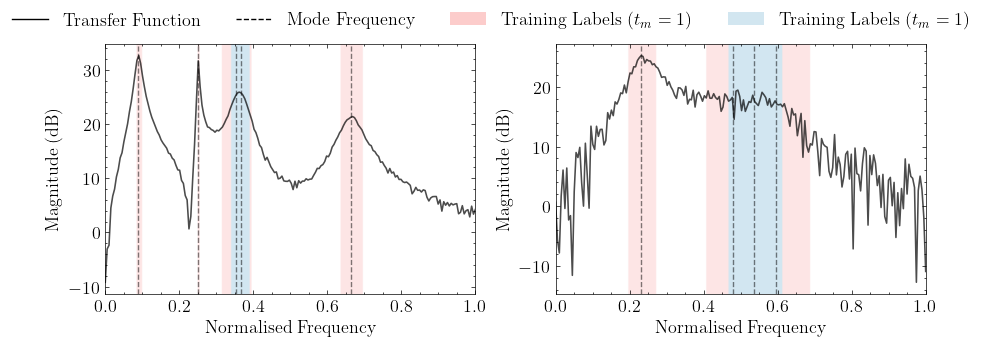

In [561]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (9,3), constrained_layout=True)
single_color1 = mcolors.LinearSegmentedColormap.from_list("", ["white", "#fb9a99"]) # red
single_color2 = mcolors.LinearSegmentedColormap.from_list("", ["white", "#a6cee3"]) # blue

X, y, ws, __ = generate_dat_extended(32, 200, sigma_max=np.log(1e-0), neg_an=True, max_modes=5, multiclass=True, normalise=None, norm_95=False)
indices = np.random.randint(0, X.shape[0], 2)
for i, idx in enumerate(indices):
    tf = X[idx, :, :2]
    y2 = y[idx]
    w = np.linspace(0, 1, len(y2))
    mask = np.zeros_like(w)
    mask[y2 == 1] = 1
    mask2 = np.zeros_like(w)
    mask2[y2 == 2] = 1

    ax[i].plot(w, modal.to_db(tf), label = 'Transfer Function', c='black', alpha=0.7, linewidth=1.15)
    ax[i].imshow(mask.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap=single_color1, alpha=0.5)
    ax[i].imshow(mask2.reshape(1, -1), aspect='auto', extent=[0, 1, ax[i].get_ylim()[0], ax[i].get_ylim()[1]], cmap=single_color2, alpha=0.5)

    ws2 = ws[idx]
    if ws2 is not None:
        for w_n in ws2:
                ax[i].axvline(w_n, c='black', linestyle='--', alpha=0.5)

    ax[i].set_xlabel('Normalised Frequency')
    ax[i].set_ylabel('Magnitude (dB)')

legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#fb9a99', edgecolor='none', alpha=0.5, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#a6cee3', edgecolor='none', alpha=0.5, label='Training Labels $(t_m = 1)$')
legend_elements.append(rect)

fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
           bbox_transform=fig.transFigure,
           ncol=4, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )
plt.savefig('./Figs/training_multiclass.pdf')
plt.show()

#### Weights comparison

In [861]:
def compare_models_multiclass(model1, model2, max_norm=False, method=1, nrows=2, ncols=2, figsize=(6,5.5), name1=None, name2=None, show_legend=True):
    valX, valy, ws, __ = generate_dat_extended(8*1, 500, neg_an=True, sigma_max=np.log(0.2), max_modes=6, multiclass=True, norm_95=max_norm, method=method, a_max=2.0)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model1.eval()
    model2.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs1 = model1(val_inputs)
            val_outputs2 = model2(val_inputs)

    plot_predictions(val_inputs, val_outputs1, val_targets, ws=ws, nrows=nrows, ncols=ncols, multiclass=True, figsize=figsize, name=name1, show_legend=show_legend)
    plot_predictions(val_inputs, val_outputs2, val_targets, ws=ws, nrows=nrows, ncols=ncols, multiclass=True, figsize=figsize, name=name2, show_legend=show_legend)

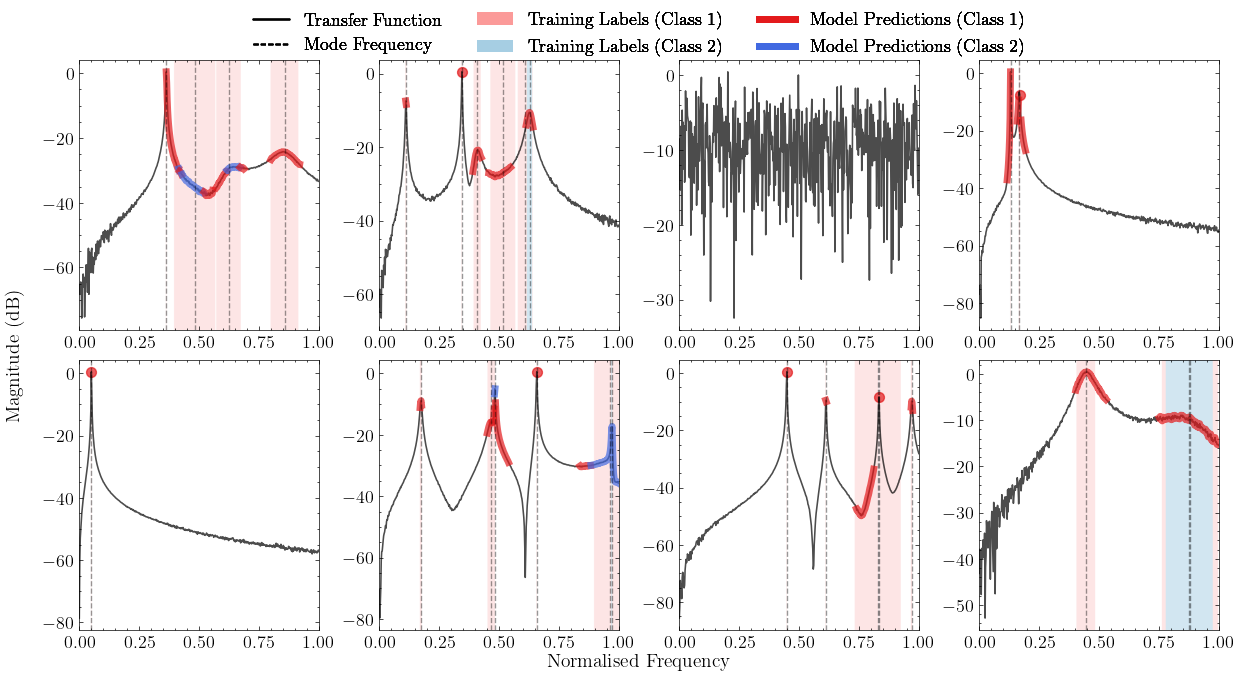

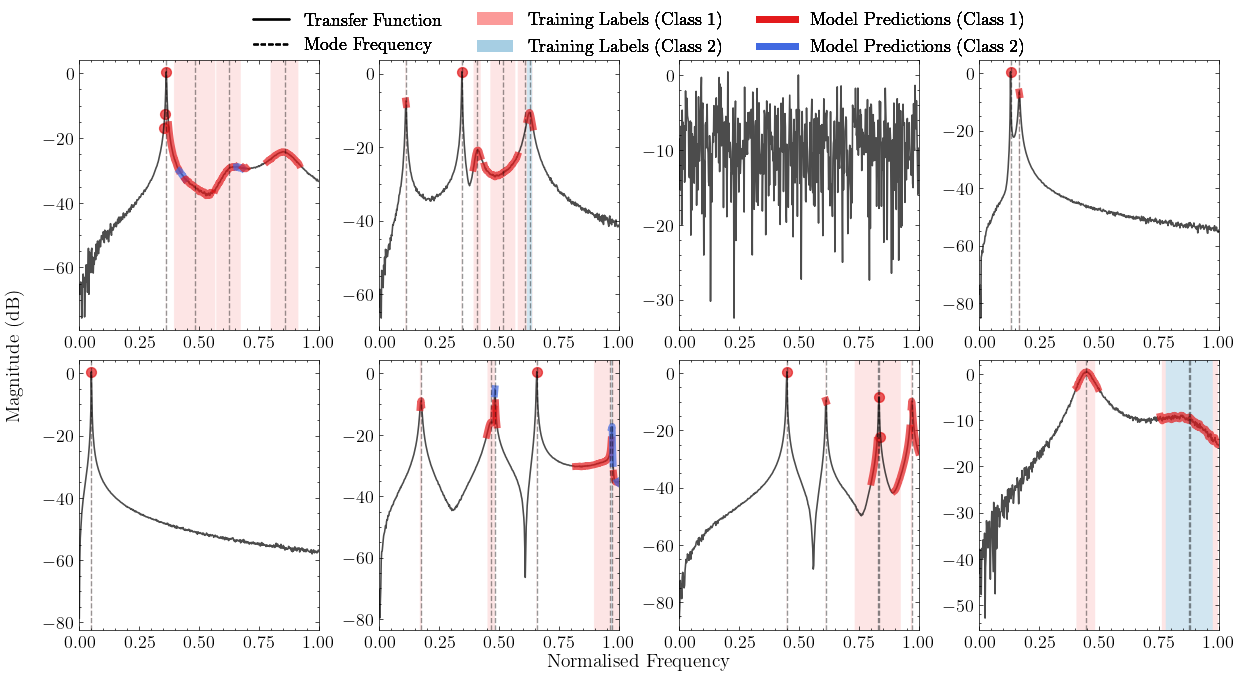

In [1030]:
compare_models_multiclass(extended8, extended7, max_norm=True, method=2, ncols=4, figsize=(12,6), name2='final_predictions_setB')

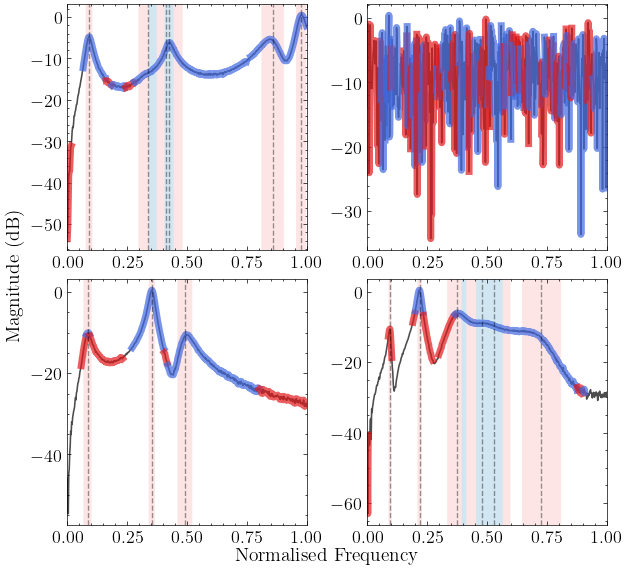

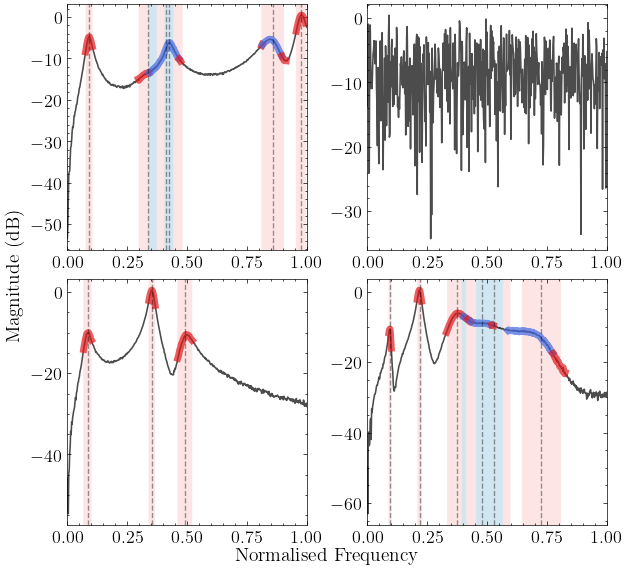

In [793]:
compare_models_multiclass(extended1, extended3, max_norm=True, method=1, ncols=2, figsize=(6,5.5), show_legend=False, name1='weights_bad', name2='weights_good')

In [1047]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#fb9a99', edgecolor='none', alpha=0.5, label='Training Labels (Class 1)')
legend_elements.append(rect)
rect = patches.Rectangle((0, 0), 1, 1, facecolor='#a6cee3', edgecolor='none', alpha=0.5, label='Training Labels (Class 2)')
legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='#e31a1c', alpha=0.7, linewidth=5, label='Model Predictions (Class 1)'))
legend_elements.append(plt.Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=5, label='Model Predictions (Class 2)'))
legend = fig.legend(handles=legend_elements, loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=3, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )
def export_legend(legend, filename="./Figs/legend_multiclass.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

### Final Model

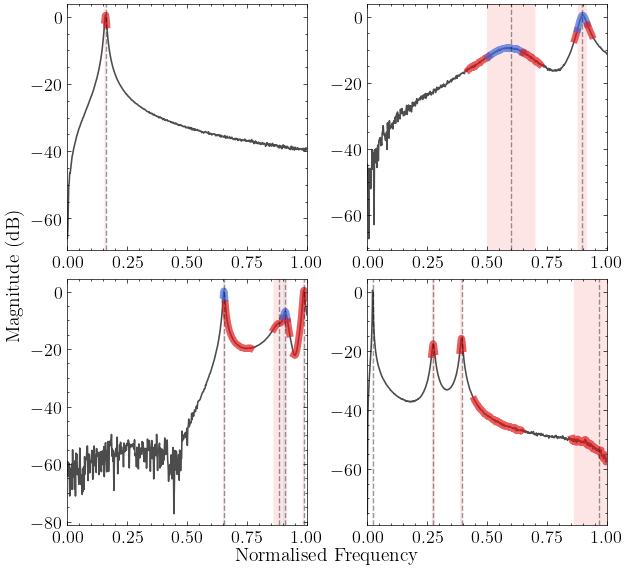

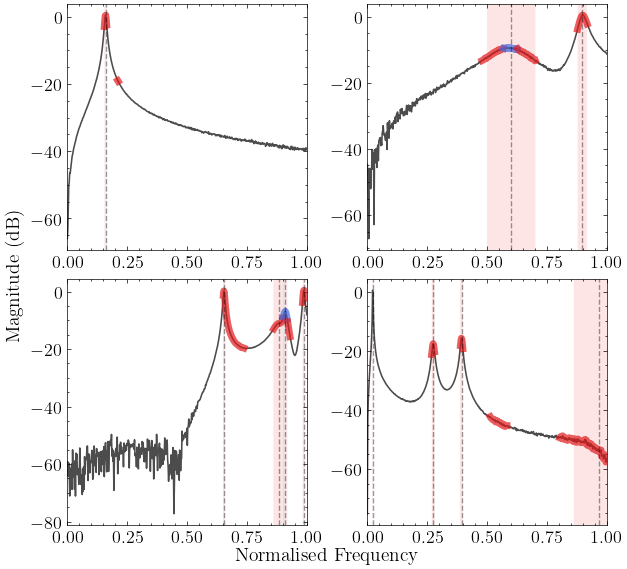

In [815]:
compare_models_multiclass(extended9, extended10, max_norm=True, method=2, ncols=2, figsize=(6,5.5), show_legend=False)

### Lab stuff

In [1049]:
def lab_predictions(model, tf_arr, multiclass=False, normalise = None, extended=False, w=None, max_norm=False, phase=False, logmag=False, scaled_logmag=False, plot_tf=True, name=None):
    """Predictions from a trained model on a given transfer function."""

    if extended:
        if normalise is not None:
            tf_arr2 = normalise(tf_arr)
            real_imag = modal.split_real_imag(tf_arr2)
            extended_tf = lab.extend_lab_tf(tf_arr)
            extended_tf[:,0] = real_imag[:,0]
            extended_tf[:,1] = real_imag[:,1]
        else:
            if max_norm:
                real_imag = modal.split_real_imag(tf_arr)
                phase = np.arctan(np.imag(tf_arr)/np.real(tf_arr))
                if phase is True:
                    phase = np.mod(phase, 2*np.pi) # phase is between 0 and 2pi
                mag = np.abs(tf_arr)
                max_mag = np.max(mag)
                mag = mag / (0.95 * max_mag)
                real_imag = real_imag / (0.95 * max_mag)
                if logmag is True:
                    logmagnitude = np.log10(mag)
                    if scaled_logmag is True:
                        logmagnitude = (logmagnitude - np.mean(logmagnitude)) / np.std(logmagnitude)
                    extended_tf = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1), logmagnitude.reshape(-1,1)), axis=1)
                else:
                    extended_tf = np.concatenate((real_imag, phase.reshape(-1,1), mag.reshape(-1,1)), axis=1)

            else:
                extended_tf = lab.extend_lab_tf(tf_arr)
        lab_tf_tensor = torch.from_numpy(extended_tf).to(torch.float32)
    else:
        lab_tf = modal.split_real_imag(tf_arr).reshape(1, -1, 2)
        if normalise is not None:
            lab_tf = normalise(lab_tf)
        lab_tf_tensor = torch.from_numpy(lab_tf).to(torch.float32)

    model.eval()
    with torch.no_grad():
        lab_tf_output = model(lab_tf_tensor)
    
    if multiclass:
        test_op = np.array(lab_tf_output.numpy())
        predictions = np.argmax(test_op, axis=-1).reshape(-1)
    else:
        test_op = lab_tf_output.numpy().reshape(-1)
        predictions = (test_op > 0.0).astype(int)
    
    input_tf = modal.split_real_imag(tf_arr)
    y = predictions
    # print(y)

    fig, ax = plt.subplots(figsize=(7,4))
    if w is None:
        w = np.linspace(0, 1, len(y))
    if normalise is not None:
        tf = modal.to_db(normalise(input_tf))
    elif max_norm is True:
        tf = modal.to_db(real_imag)
    else:
        tf = modal.to_db(input_tf)

    if plot_tf is True:
        if multiclass:
            segment_start = None
            segment_color = None
            ax.plot(w, tf, label = 'Transfer Function', c='black', alpha=0.9, linewidth=1.15)
            for i in range(len(w)):
                if predictions[i] == 1 and (segment_start is None or segment_color != '#e31a1c'): #red
                    if segment_start is not None:
                        ax.plot(w[segment_start:i], tf[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = i
                    segment_color = '#e31a1c'
                elif predictions[i] == 2 and (segment_start is None or segment_color != 'royalblue'): #blue #1f78b4
                    if segment_start is not None:
                        ax.plot(w[segment_start:i], tf[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = i
                    segment_color = 'royalblue'
                elif predictions[i] != 1 and predictions[i] != 2 and segment_start is not None:
                    if i == segment_start + 1:
                        ax.scatter(w[segment_start], tf[segment_start], c=segment_color,alpha=0.7, s=50)
                    ax.plot(w[segment_start:i], tf[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')
                    segment_start = None
                    segment_color = None
            if segment_start is not None:
                ax.plot(w[segment_start:i], tf[segment_start:i], c=segment_color, alpha=0.7, linewidth=5, label=f'Predicted={segment_color[-1]}')


            # legend_elements = []
            # legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
            # legend_elements.append(plt.Line2D([0], [0], color='#e31a1c', alpha=0.7, linewidth=5, label='Model Predictions (Class 1)'))
            # legend_elements.append(plt.Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=5, label='Model Predictions (Class 2)'))

            # fig.legend(handles=legend_elements, loc='upper center', 
            #         bbox_to_anchor=(0.5, 1.),
            #         # bbox_to_anchor=(0.5, -0),
            #         bbox_transform=fig.transFigure,
            #         ncol=3, 
            #         fancybox=True, 
            #         #   shadow=True,
            #             # frameon=True,
            #             )

        else:
            segment_start = None
            for i in range(len(w)):
                if predictions[i] == 1:
                    if segment_start is None:
                        segment_start = i
                elif segment_start is not None:
                    ax.plot(w[segment_start:i], tf[segment_start:i], c="red", alpha=0.7, linewidth=5, label='Predicted=1')
                    segment_start = None
            ax.plot(w, tf, label = 'Transfer Function', c='blue', alpha=0.7, linewidth=1.15)


        
        # if multiclass:
            # ax.scatter(w[y == 2], tf[y == 2], c='orange', marker='o', label=r'Model Predictions (Class 2)')
        if w is not None:
            ax.set_xlabel('Frequency (rad/s)')
        else:
            ax.set_xlabel('Normalised Frequency')
        ax.set_ylabel('Magnitude (dB)')
        # ax.legend()
        if name is not None:
            plt.savefig(f'./Figs/{name}.pdf')
        plt.show()

    # return test_op

In [13]:
def load_sampling_data(cutoff=-1, f_s=3000, tf_type="vel", num_tfs=1):
    """
    cutoff: upper limit on sample number (only predict on certain number of measurements)
    f_s: sampling frequency
    tf_type: transfer function type (displacement, velocity or acceleration)
    num_tfs: the number of transfer functions to load
    """
    assert tf_type in ["disp", "vel", "acc"]

    d = dvma.load_data()
    freqs = d.tf_data_list[0].freq_axis
    faxis = np.fft.rfftfreq(2 * d.tf_data_list[0].tf_data.shape[0] - 1, d=1/f_s) # shape (4501,)
    waxis = 2 * np.pi * faxis[:cutoff]

    if num_tfs > 1:
        tf_dict = {}
        for i in range(num_tfs):
            tf_dict[f'tf_{i}'] = d.tf_data_list[i].tf_data[1:].reshape(-1)
            if tf_type == "acc":
                waxis[0] = waxis[1] / 3 # ??
                tf_dict[f'tf_{i}']  = tf_dict[f'tf_{i}'] / (1j * waxis)
            elif tf_type == "disp":
                tf_dict[f'tf_{i}']  = tf_dict[f'tf_{i}'] * (1j * waxis)
        return tf_dict, waxis
    else:
        tf = d.tf_data_list[0].tf_data[:cutoff]
        if tf_type == "acc":
            tf = tf / (1j * waxis)
        elif tf_type == "disp":
            tf = tf * waxis
        return tf, waxis

In [1032]:
tf, waxis = load_sampling_data(f_s=3000, tf_type="vel")

2024-05-23 11:39:46.217 python[31038:67415303] +[CATransaction synchronize] called within transaction


In [1034]:
tf_noisy, waxis_noisy = load_sampling_data(f_s=3000, tf_type="vel")

2024-05-23 11:40:48.950 python[31038:67415303] +[CATransaction synchronize] called within transaction


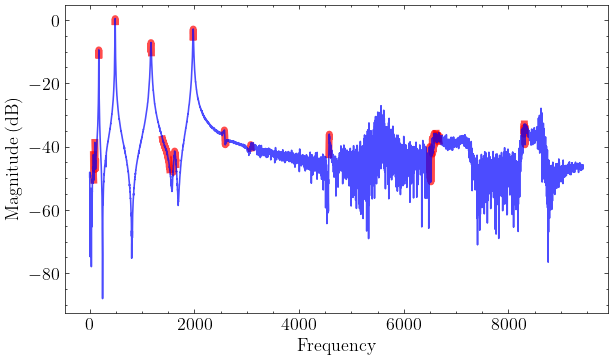

array([[ 4.7246366, -4.0012593, -5.7932   ],
       [ 6.3791237, -5.685784 , -7.917913 ],
       [ 7.048541 , -6.4245133, -9.474682 ],
       ...,
       [ 4.123396 , -3.3834603, -7.6724095],
       [ 4.0910673, -3.3430972, -7.623786 ],
       [ 3.9664738, -2.8837829, -6.5989857]], dtype=float32)

In [47]:
lab_predictions(extended=True, model=extended7, tf_arr=tf,w=waxis, multiclass=True, max_norm=True, name='final_3c6')

#### beam bit

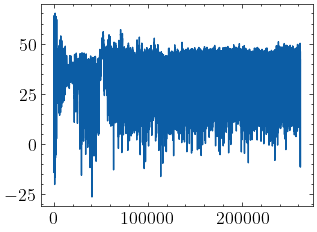

In [565]:
beam_data = scipy.io.loadmat('./Lab Data/Beam/G_set.mat')
beam_tf = beam_data['yspec'][:, -1] # shape = (262145,)

In [822]:
faxis = np.fft.rfftfreq(2 * beam_tf.shape[0] - 1, d=1/100000)[1:]
waxis = 2 * np.pi * faxis
beam_tf_vel = beam_tf[1:] / (1j * waxis)
beam_tf_vel = beam_tf_vel

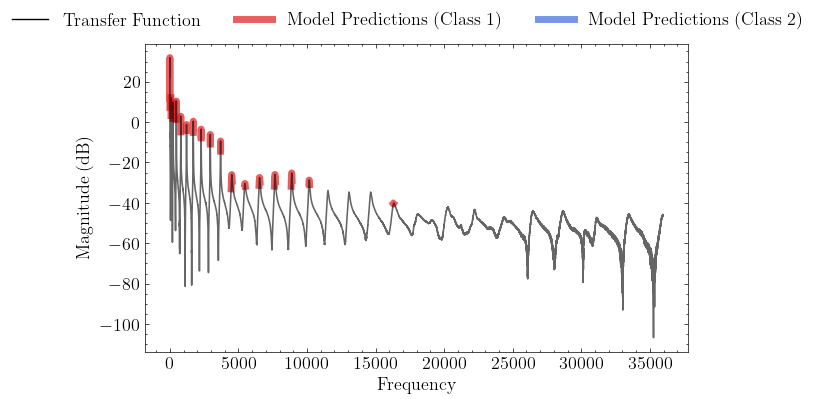

In [823]:
lab_predictions(extended=True, model=jan3_multi, tf_arr=beam_tf_vel[:30000],w=waxis[:30000], multiclass=True, max_norm=False, name='beam_tf_unscaled')

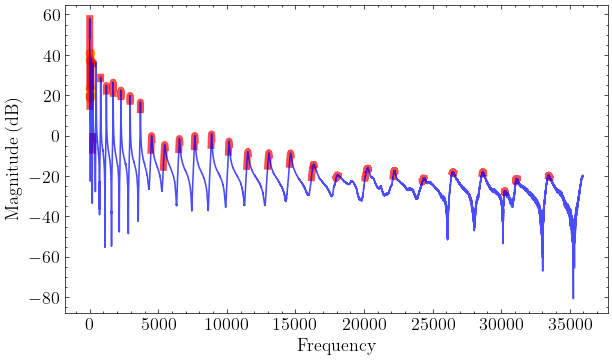

In [577]:
lab_predictions(extended=True, model=jan3_multi, tf_arr=20*beam_tf_vel[:30000],w=waxis[:30000], multiclass=True, max_norm=False, name ='beam_tf_scaled')

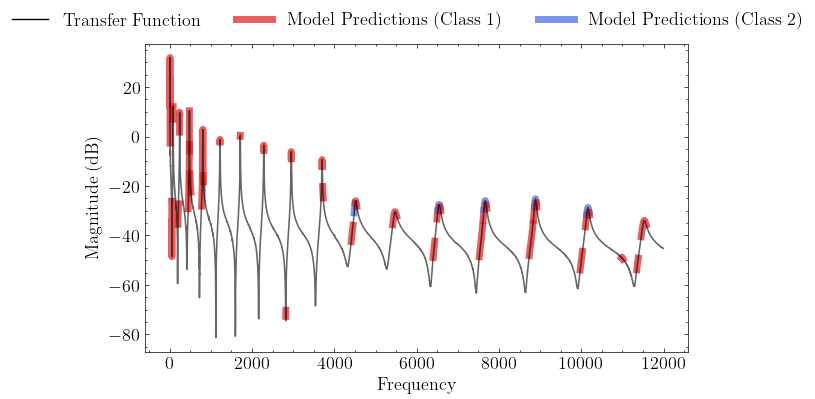

In [829]:
lab_predictions(extended=True, model=extended6, tf_arr=beam_tf_vel[:10000],w=waxis[:10000], multiclass=True, max_norm=False)

#### logmag

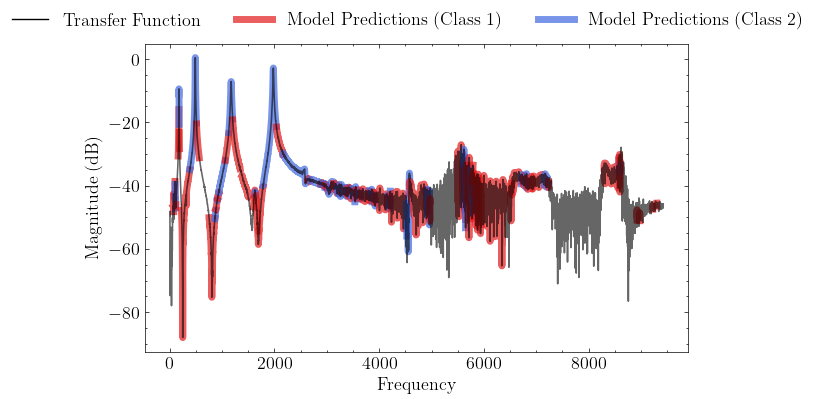

In [660]:
lab_predictions(extended=True, model=scaledlogmag5, tf_arr=tf,w=waxis, multiclass=True, max_norm=True, logmag=True, scaled_logmag=True)

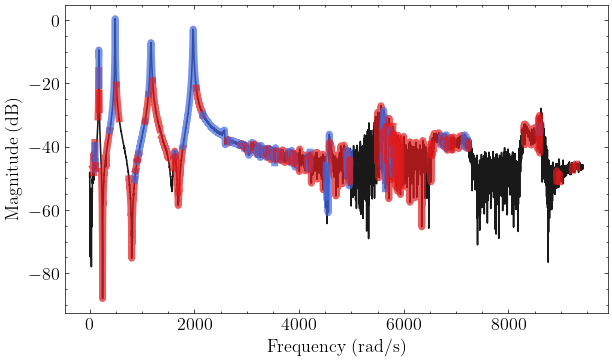

In [1056]:
lab_predictions(extended=True, model=scaledlogmag5, tf_arr=tf,w=waxis, multiclass=True, max_norm=True, name='logmag_3c6', logmag=True, scaled_logmag=True)

#### 3C6

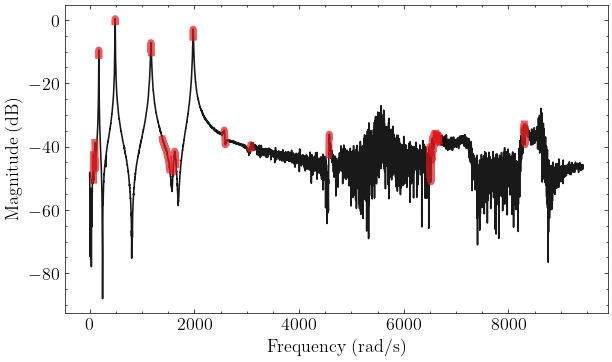

In [1052]:
lab_predictions(extended=True, model=extended7, tf_arr=tf,w=waxis, multiclass=True, max_norm=True, name='final_3c6')

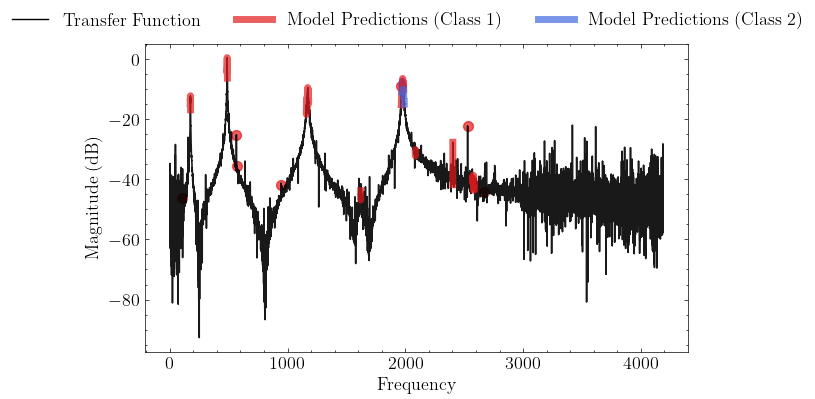

In [1045]:
lab_predictions(extended=True, model=extended7, tf_arr=tf_noisy[:20000],w=waxis_noisy[:20000], multiclass=True, max_norm=True)

In [1046]:
fig = plt.figure()
legend_elements = []
legend_elements.append(plt.Line2D([0], [0], color='black', label='Transfer Function'))
# legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mode Frequency'))
# rect = patches.Rectangle((0, 0), 1, 1, facecolor='#fb9a99', edgecolor='none', alpha=0.5, label='Training Labels $(t_m = 1)$')
# legend_elements.append(rect)
# rect = patches.Rectangle((0, 0), 1, 1, facecolor='#a6cee3', edgecolor='none', alpha=0.5, label='Training Labels $(t_m = 1)$')
# legend_elements.append(rect)
legend_elements.append(plt.Line2D([0], [0], color='#e31a1c', alpha=0.7, linewidth=5, label='Model Predictions (Class 1)'))
legend_elements.append(plt.Line2D([0], [0], color='royalblue', alpha=0.7, linewidth=5, label='Model Predictions (Class 2)'))
legend = fig.legend(handles=legend_elements, loc='upper center', 
        #    bbox_to_anchor=(0.5, 1.15),
        # bbox_to_anchor=(0.5, -0),
        #    bbox_transform=fig.transFigure,
           ncol=3, 
          fancybox=True, 
        #   shadow=True,
            # frameon=True,
            )
def export_legend(legend, filename="./Figs/legend_lab_multiclass.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", 
                # bbox_inches=bbox,
                )

export_legend(legend)
plt.show()

<Figure size 350x262.5 with 0 Axes>

#### 4C6

In [969]:
tf_dict, waxis_4c6 = load_sampling_data(tf_type="acc", num_tfs=12)

2024-05-23 10:56:30.571 python[31038:67415303] +[CATransaction synchronize] called within transaction


/var/folders/mw/j7jd8sy576gdhd74r9ppm1qc0000gn/T/ipykernel_31038/3430648253.py:14: RuntimeWarning: divide by zero encountered in divide
  phase = np.arctan(np.imag(tf_arr)/np.real(tf_arr))


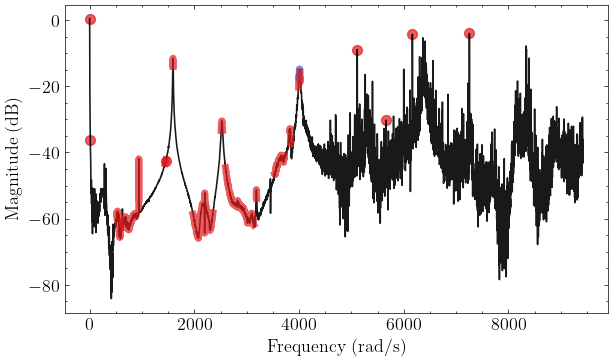

In [1054]:
lab_predictions(extended=True, model=extended7, tf_arr=tf_dict['tf_4'],w=waxis_4c6, multiclass=True, max_norm=True, name='final_4c6')